In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3" # which gpu to use
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as sk_mae
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True # dont allocate entire vram initially
set_session(tf.Session(config=config))
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras.metrics import mean_absolute_error
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

C:\Users\son\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
#Keras image processing
IMG_SIZE = (224, 224) # default size for inception_v3
def flow_from_dataframe(in_df, path_col, y_col, **dflow_args):
    img_data_gen = ImageDataGenerator(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.15, 
                              width_shift_range = 0.15, 
                              rotation_range = 5, 
                              shear_range = 0.01,
                              fill_mode = 'reflect',
                              zoom_range=0.25,
                             preprocessing_function = preprocess_input)
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, class_mode = 'sparse',**dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

12611 images found out of total 12611 images
          id  boneage   male                                path  exists  \
7435    9823      156  False   boneage-training-dataset/9823.png    True   
12173  15128      132   True  boneage-training-dataset/15128.png    True   
6542    8836      156   True   boneage-training-dataset/8836.png    True   
9923   12608      162  False  boneage-training-dataset/12608.png    True   
267     1675       96   True   boneage-training-dataset/1675.png    True   

       gender    zscore  
7435   female  0.696402  
12173    male  0.113624  
6542     male  0.696402  
9923   female  0.842097  
267      male -0.760544  


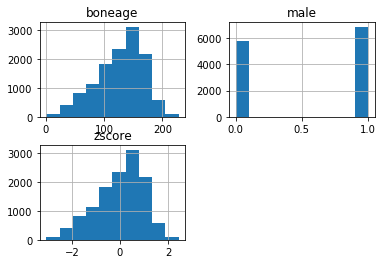

In [4]:
#Read the data
img_dir = "boneage-training-dataset/"
csv_path = "boneage-training-dataset.csv"
age_df = pd.read_csv(csv_path)
age_df['path'] = age_df['id'].map(lambda x: img_dir+"{}.png".format(x))
age_df['exists'] = age_df['path'].map(os.path.exists)
age_df['gender'] = age_df['male'].map(lambda x: "male" if x else "female")
mu = age_df['boneage'].mean()
sigma = age_df['boneage'].std()
age_df['zscore'] = age_df['boneage'].map(lambda x: (x-mu)/sigma)
age_df.dropna(inplace=True)

#Examine the distribution of age and gender
print("{} images found out of total {} images".format(age_df['exists'].sum(),age_df.shape[0]))
print(age_df.sample(5))
age_df[['boneage','male','zscore']].hist()
plt.show()

#Split into training testing and validation datasets
age_df['boneage_category'] = pd.cut(age_df['boneage'], 10)
raw_train_df, test_df = train_test_split(age_df, 
                                   test_size = 0.2, 
                                   random_state = 2018,
                                   stratify = age_df['boneage_category'])
raw_train_df, valid_df = train_test_split(raw_train_df, 
                                   test_size = 0.1,
                                   random_state = 2018,
                                   stratify = raw_train_df['boneage_category'])

         id  boneage   male                                path  exists  \
8017   3273      204  False   boneage-training-dataset/3273.png    True   
7681  13847      180   True  boneage-training-dataset/13847.png    True   
6870   4814      156   True   boneage-training-dataset/4814.png    True   
9988   5964      216   True   boneage-training-dataset/5964.png    True   
7184   5605      162  False   boneage-training-dataset/5605.png    True   

      gender    zscore boneage_category  
8017  female  1.861959   (182.6, 205.3]  
7681    male  1.279181   (159.9, 182.6]  
6870    male  0.696402   (137.2, 159.9]  
9988    male  2.153349   (205.3, 228.0]  
7184  female  0.842097   (159.9, 182.6]  


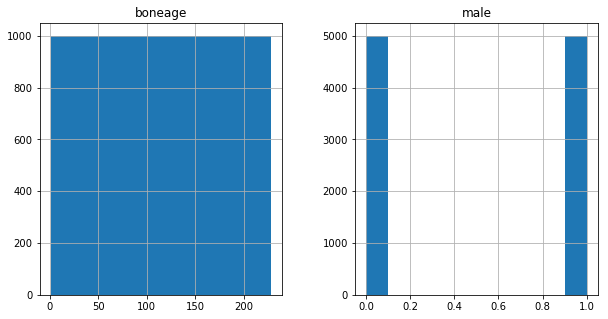

# Training images:   10000
# Validation images: 1009
# Testing images:    2523


In [5]:
#Balance the distribution in the training set
train_df = raw_train_df.groupby(['boneage_category', 'male']).apply(lambda x: x.sample(500, replace = True)).reset_index(drop=True)
print(train_df.sample(5))
train_df[['boneage', 'male']].hist(figsize = (10, 5))
plt.show()
train_size=train_df.shape[0]
valid_size=valid_df.shape[0]
test_size=test_df.shape[0]
print("# Training images:   {}".format(train_size))
print("# Validation images: {}".format(valid_size))
print("# Testing images:    {}".format(test_size))

In [6]:
#Make image batch generators
train_gen = flow_from_dataframe(train_df, 
                             path_col = 'path',
                            y_col = 'zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 10)
# Used a fixed dataset as validation set for monitoring training progress and saving best model
valid_X, valid_Y = next(flow_from_dataframe(valid_df, 
                             path_col = 'path',
                            y_col = 'zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = valid_size)) # one big batch
IMG_SHAPE = valid_X[0,:,:,:].shape
print("Image shape: "+str(IMG_SHAPE))

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 10000 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 1009 images


TypeError: 'Image' object is not subscriptable